In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import numpy as np
from tqdm import tqdm
import pickle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torchvision.models.resnet50(pretrained=True)
model = model.to(device)
model.eval()

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_dataset = ImageFolder('/kaggle/input/imagenet1k-val/imagenet-val', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)

activations = {}
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

layer_names = []
for name, module in model.named_modules():
    if isinstance(module, torch.nn.ReLU):
        layer_names.append(name)
        module.register_forward_hook(get_activation(name))

print("Collecting activations...")
class_activations = {name: [] for name in layer_names}
class_labels = []

with torch.no_grad():
    for images, labels in tqdm(val_loader):
        images = images.to(device)
        outputs = model(images)
        
        for name in layer_names:
            class_activations[name].append(activations[name].mean(dim=(2, 3)))
        
        class_labels.extend(labels.numpy())

for name in layer_names:
    class_activations[name] = torch.cat(class_activations[name], dim=0)

save_data = {
    'activations': class_activations,
    'labels': class_labels,
    'layer_names': layer_names
}

print("Saving activations...")
with open('imagenet_activations.pkl', 'wb') as f:
    pickle.dump(save_data, f)

print("Done!")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 193MB/s] 


100%|██████████| 3125/3125 [03:24<00:00, 15.30it/s]


Saving activations...
Done!


Loading saved activations...

Computing metrics...


Computing selectivity: 100%|██████████| 17/17 [00:00<00:00, 91.22it/s] 


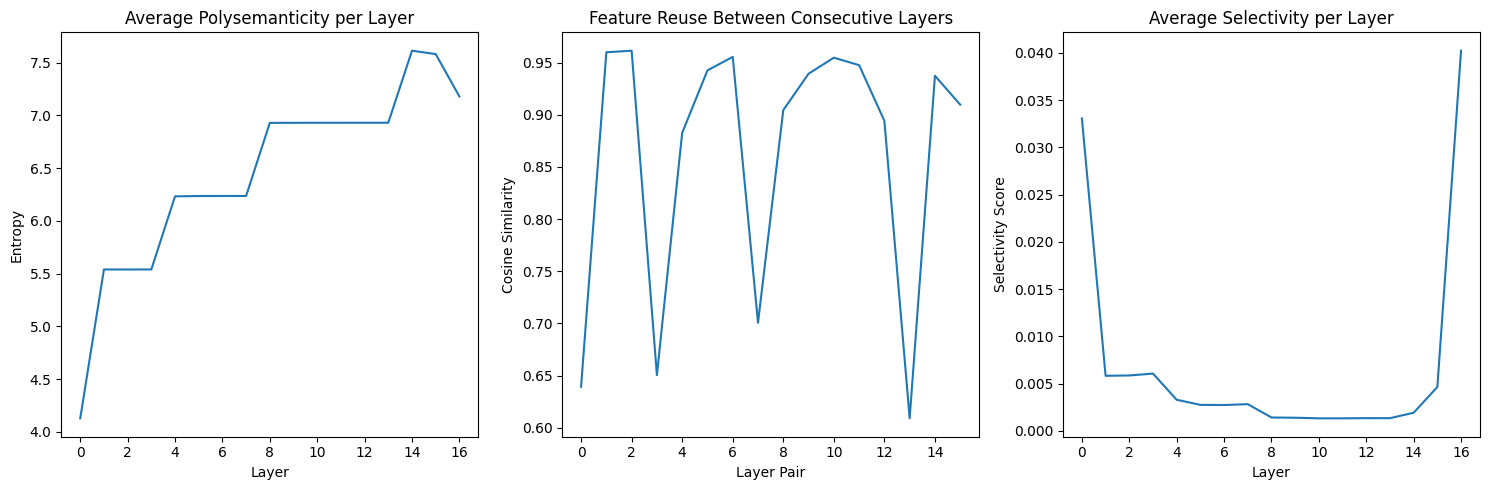


Summary Statistics:

Average Polysemanticity per layer:
relu: 4.127
layer1.0.relu: 5.539
layer1.1.relu: 5.539
layer1.2.relu: 5.539
layer2.0.relu: 6.233
layer2.1.relu: 6.236
layer2.2.relu: 6.236
layer2.3.relu: 6.236
layer3.0.relu: 6.929
layer3.1.relu: 6.930
layer3.2.relu: 6.930
layer3.3.relu: 6.930
layer3.4.relu: 6.930
layer3.5.relu: 6.931
layer4.0.relu: 7.614
layer4.1.relu: 7.582
layer4.2.relu: 7.180

Feature Reuse between consecutive layers:
relu_to_layer1.0.relu: 0.639
layer1.0.relu_to_layer1.1.relu: 0.960
layer1.1.relu_to_layer1.2.relu: 0.961
layer1.2.relu_to_layer2.0.relu: 0.650
layer2.0.relu_to_layer2.1.relu: 0.883
layer2.1.relu_to_layer2.2.relu: 0.943
layer2.2.relu_to_layer2.3.relu: 0.956
layer2.3.relu_to_layer3.0.relu: 0.701
layer3.0.relu_to_layer3.1.relu: 0.905
layer3.1.relu_to_layer3.2.relu: 0.939
layer3.2.relu_to_layer3.3.relu: 0.955
layer3.3.relu_to_layer3.4.relu: 0.948
layer3.4.relu_to_layer3.5.relu: 0.894
layer3.5.relu_to_layer4.0.relu: 0.609
layer4.0.relu_to_layer4.1.rel

In [8]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy.stats import entropy
import pickle
from tqdm import tqdm
import numpy as np

print("Loading saved activations...")
with open('imagenet_activations.pkl', 'rb') as f:
    saved_data = pickle.load(f)
    class_activations = saved_data['activations']
    class_labels = saved_data['labels']
    layer_names = saved_data['layer_names']

def compute_neuron_entropy(activations_per_class, batch_size=2000):
    total_samples = activations_per_class.shape[0]
    entropies = []
    
    for start_idx in range(0, total_samples, batch_size):
        end_idx = min(start_idx + batch_size, total_samples)
        batch = activations_per_class[start_idx:end_idx]
        
        log_probs = F.log_softmax(batch, dim=1)
        probs = torch.exp(log_probs)
        batch_entropy = entropy(probs.cpu().numpy(), axis=1)
        entropies.append(batch_entropy)
        
        torch.cuda.empty_cache()
    
    return np.concatenate(entropies)

def compute_feature_reuse(prev_layer_acts, curr_layer_acts, batch_size=100):
    total_samples = prev_layer_acts.shape[0]
    similarity_sum = 0
    num_batches = 0
    
    prev_layer_acts = prev_layer_acts.cpu()
    curr_layer_acts = curr_layer_acts.cpu()
    
    # Get the larger of the two feature dimensions
    target_size = max(prev_layer_acts.shape[1], curr_layer_acts.shape[1])
    
    for start_idx in range(0, total_samples, batch_size):
        end_idx = min(start_idx + batch_size, total_samples)
        
        prev_batch = prev_layer_acts[start_idx:end_idx]  # [batch, prev_features]
        curr_batch = curr_layer_acts[start_idx:end_idx]  # [batch, curr_features]
        
        # Interpolate both to the target size
        prev_batch = F.interpolate(
            prev_batch.unsqueeze(0), 
            size=target_size, 
            mode='linear'
        ).squeeze(0)
        
        curr_batch = F.interpolate(
            curr_batch.unsqueeze(0), 
            size=target_size, 
            mode='linear'
        ).squeeze(0)
        
        # Normalize 
        prev_norm = F.normalize(prev_batch, p=2, dim=1)
        curr_norm = F.normalize(curr_batch, p=2, dim=1)
        

        similarities = F.cosine_similarity(prev_norm, curr_norm)
        similarity_sum += similarities.sum().item()
        num_batches += similarities.shape[0]
        
        torch.cuda.empty_cache()
    
    return similarity_sum / num_batches

def compute_selectivity(activations_per_class, batch_size=2000):
    total_samples = activations_per_class.shape[0]
    selectivity_scores = []
    
    for start_idx in range(0, total_samples, batch_size):
        end_idx = min(start_idx + batch_size, total_samples)
        batch = activations_per_class[start_idx:end_idx]
        
        log_probs = F.log_softmax(batch, dim=1)
        probs = torch.exp(log_probs)
        max_probs = probs.max(dim=1)[0]
        sum_probs = probs.sum(dim=1)
        batch_selectivity = (max_probs / sum_probs).cpu().numpy()
        selectivity_scores.append(batch_selectivity)
        
        torch.cuda.empty_cache()
    
    return np.concatenate(selectivity_scores)


results = {
    'polysemanticity': {},
    'feature_reuse': {},
    'selectivity': {}
}

print("\nComputing metrics...")
# 1. Compute polysemanticity scores
for name in tqdm(layer_names, desc="Computing polysemanticity"):
    results['polysemanticity'][name] = compute_neuron_entropy(class_activations[name])
    torch.cuda.empty_cache()

# 2. Compute feature reuse
for i in tqdm(range(len(layer_names)-1), desc="Computing feature reuse"):
    curr_name = layer_names[i]
    next_name = layer_names[i+1]
    results['feature_reuse'][f"{curr_name}_to_{next_name}"] = compute_feature_reuse(
        class_activations[curr_name], 
        class_activations[next_name]
    )
    torch.cuda.empty_cache()

# 3. Compute selectivity
for name in tqdm(layer_names, desc="Computing selectivity"):
    results['selectivity'][name] = compute_selectivity(class_activations[name])
    torch.cuda.empty_cache()

plt.figure(figsize=(15, 5))

# 1. Plot average polysemanticity per layer
plt.subplot(131)
avg_poly = [results['polysemanticity'][name].mean() for name in layer_names]
plt.plot(avg_poly)
plt.title('Average Polysemanticity per Layer')
plt.xlabel('Layer')
plt.ylabel('Entropy')

# 2. Plot feature reuse
plt.subplot(132)
reuse_scores = list(results['feature_reuse'].values())
plt.plot(reuse_scores)
plt.title('Feature Reuse Between Consecutive Layers')
plt.xlabel('Layer Pair')
plt.ylabel('Cosine Similarity')

# 3. Plot average selectivity per layer
plt.subplot(133)
avg_select = [results['selectivity'][name].mean() for name in layer_names]
plt.plot(avg_select)
plt.title('Average Selectivity per Layer')
plt.xlabel('Layer')
plt.ylabel('Selectivity Score')

plt.tight_layout()
plt.show()

print("\nSummary Statistics:")
print("\nAverage Polysemanticity per layer:")
for name, scores in results['polysemanticity'].items():
    print(f"{name}: {scores.mean():.3f}")

print("\nFeature Reuse between consecutive layers:")
for pair, score in results['feature_reuse'].items():
    print(f"{pair}: {score:.3f}")

print("\nAverage Selectivity per layer:")
for name, scores in results['selectivity'].items():
    print(f"{name}: {scores.mean():.3f}")